# make_grid-add_FastIceBergs:
## Standalone script to process and add icebergs and fast ice to an existing grid file

In [95]:

run ='amery'
vers='v2km'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks



out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_grd.nc')
out_path_new = os.path.join(data_dir,'proc',run+'_'+vers+'_FIbergs_grd.nc')


# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask

# Set model vertical coordinate settings

N=31
Vtransform=2
Vstretching=4
theta_s=1
theta_b=4
Tcline=250
hc=Tcline # if Vtransform==2, hc=Tcline


In [96]:
# add fast ice

# fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'*.nc') # load full fast ice data set
fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'FastIce_70_200[0-2].nc',data_vars='different') # load full fast ice data set, don't concat similar datavars (e.g. lon)

fi_full = fi_fulldata.drop(['x','y','area','date_alt'])
# fi_full = fi_full_coordCorrected

fi_full.nbytes/1e9

2.009250544

In [97]:
fi_full

<xarray.Dataset>
Dimensions:               (Y: 4700, X: 5625, time: 68)
Coordinates:
  * time                  (time) datetime64[ns] 2000-03-01 ... 2002-12-12
Dimensions without coordinates: Y, X
Data variables:
    latitude              (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    longitude             (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    Fast_Ice_Time_series  (time, Y, X) int8 dask.array<chunksize=(20, 4700, 5625), meta=np.ndarray>
Attributes:
    title:        Fast ice time series
    institution:  Institute for Marine and Antarctic Studies, University of T...
    source:       MODIS 15-day composite images and automated edge detection
    history:      Version 2.2
    references:   Fraser et al., 2020 (Earth System Science Data, submitted)
    comment:      This is the lat_ts=-70 version of the data - year 2000
    contact:      Alex Fraser (adfraser@utas.edu.au)
    Conventions:  CF-1.7

In [98]:
interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
annual_coverage_cutoff = 0.9 # Annual persistence: at least this fractional % required over the year to be considered as ice

fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6) # make the fast ice mask data array
# # check that i'm adding all the required fields
# (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
# # check that the mean is working
# (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
# plt.show()
# (fi.groupby('time.month').mean()).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff




In [99]:
grid = xr.open_dataset(out_path)
lon_rho = grid.lon_rho
lat_rho = grid.lat_rho

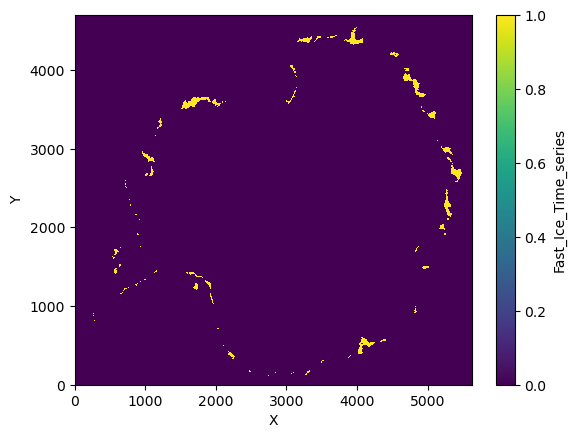

In [100]:
# now map the fast ice data to the model grid
fi_mean_annual.plot()

# interp (nearest) to the model lat/lon

fi_mean_annual_i = griddata((fi_full['longitude'].values.flatten(),fi_full['latitude'].values.flatten()),fi_mean_annual.values.flatten(),(lon_rho,lat_rho),'nearest')


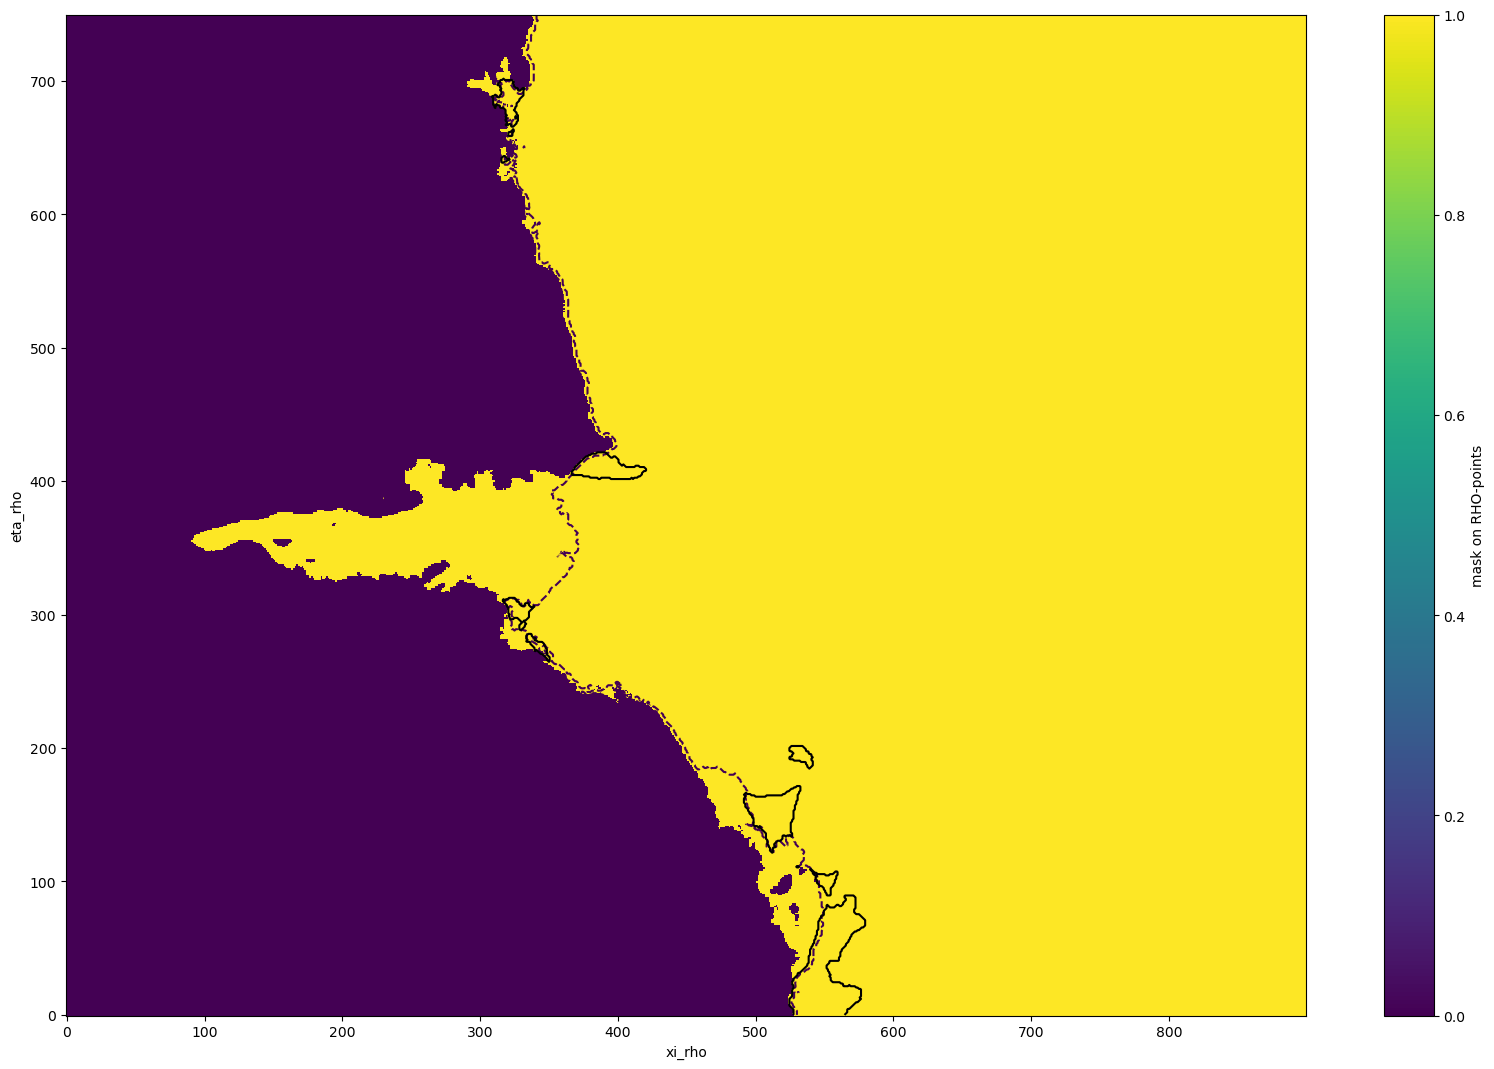

In [101]:

fig = plt.figure(figsize=(20,13))
grid.mask_rho.plot()
grid.zice.plot.contour(levels=np.array((0,-1)))

plt.contour(fi_mean_annual_i,colors='k')

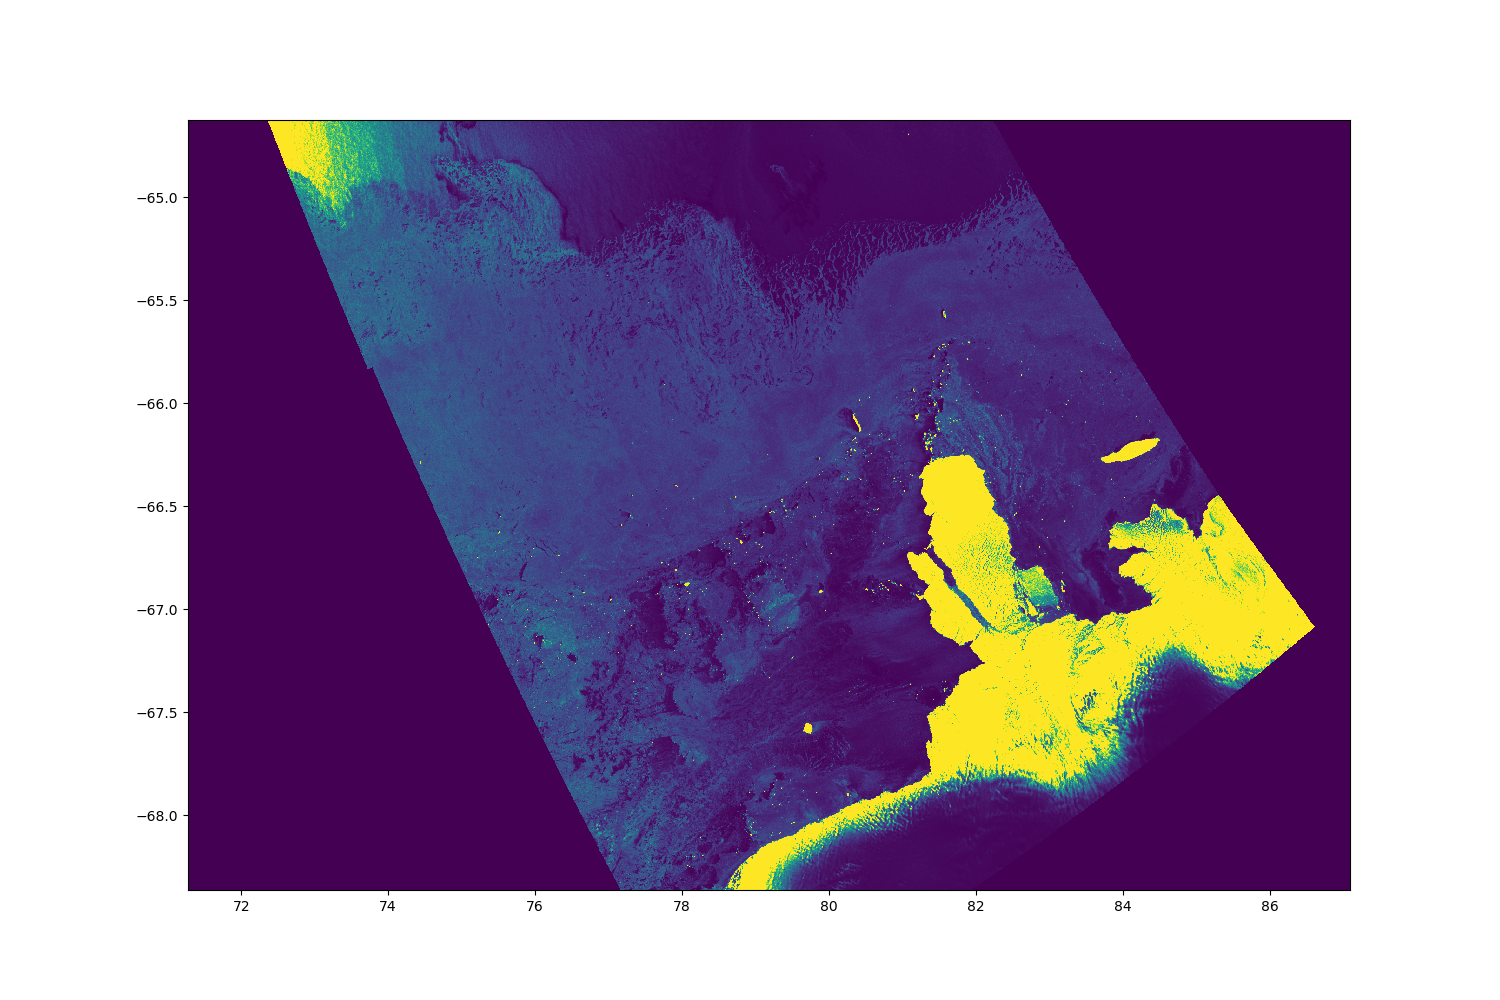

In [102]:
# add icebergs
# download from https://apps.sentinel-hub.com/eo-browser/ (need log in)
# download as a tif, georeferenced, high res, etc, Sentinel-1 AWS-EW-HHHV, HH-linear gamma0 - radiometric terrain, clip extra bands, note the coordinate system. e.g. WGS84 is EPSG:4326 
import rioxarray

S1b = rioxarray.open_rasterio('../data/raw/Sentinel/2023-05-01-00 00_2023-05-01-23 59_Sentinel-1_AWS-EW-HHHV_HH_-_linear_gamma0_-_radiometric_terrain_corrected.tiff')

# import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
%matplotlib widget
import mplcursors

fig,ax=plt.subplots(figsize=(15,10))
im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
cursor = mplcursors.cursor(im, hover=True)




In [103]:
%matplotlib inline

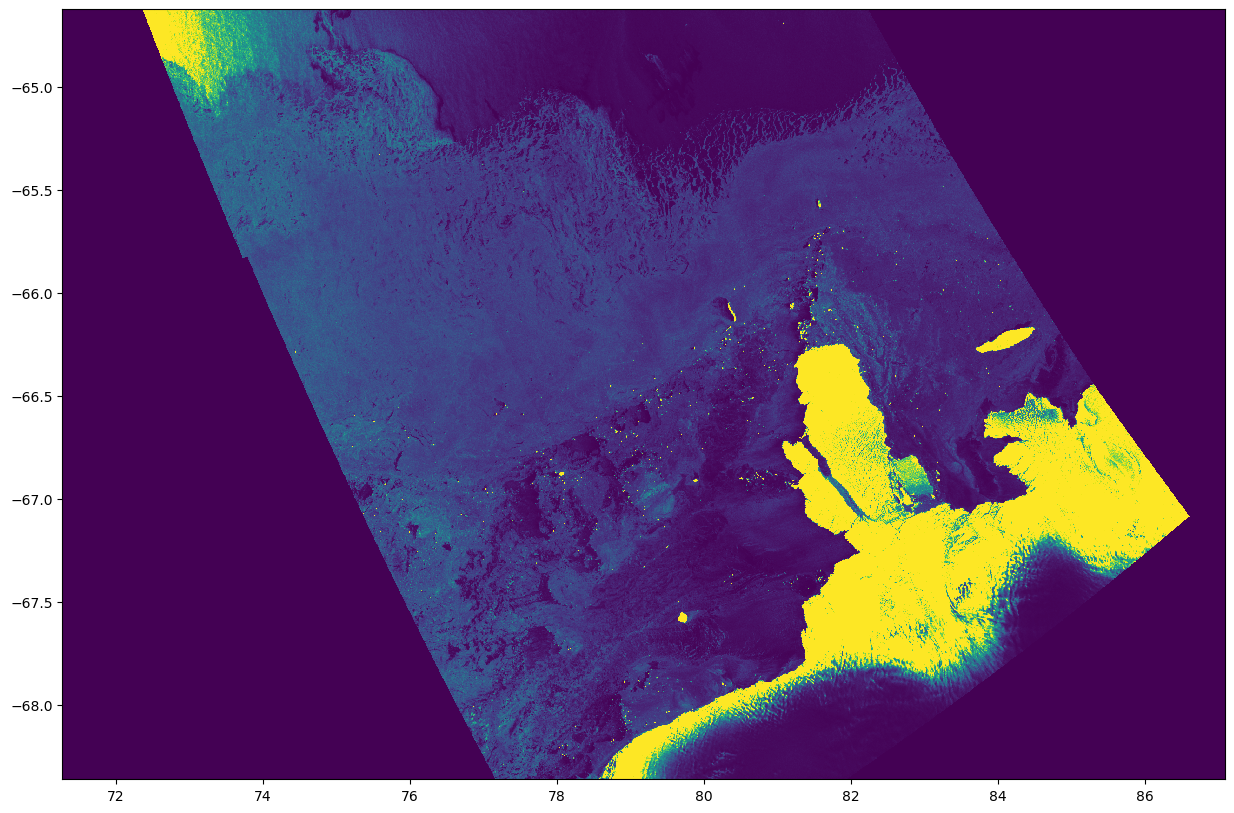

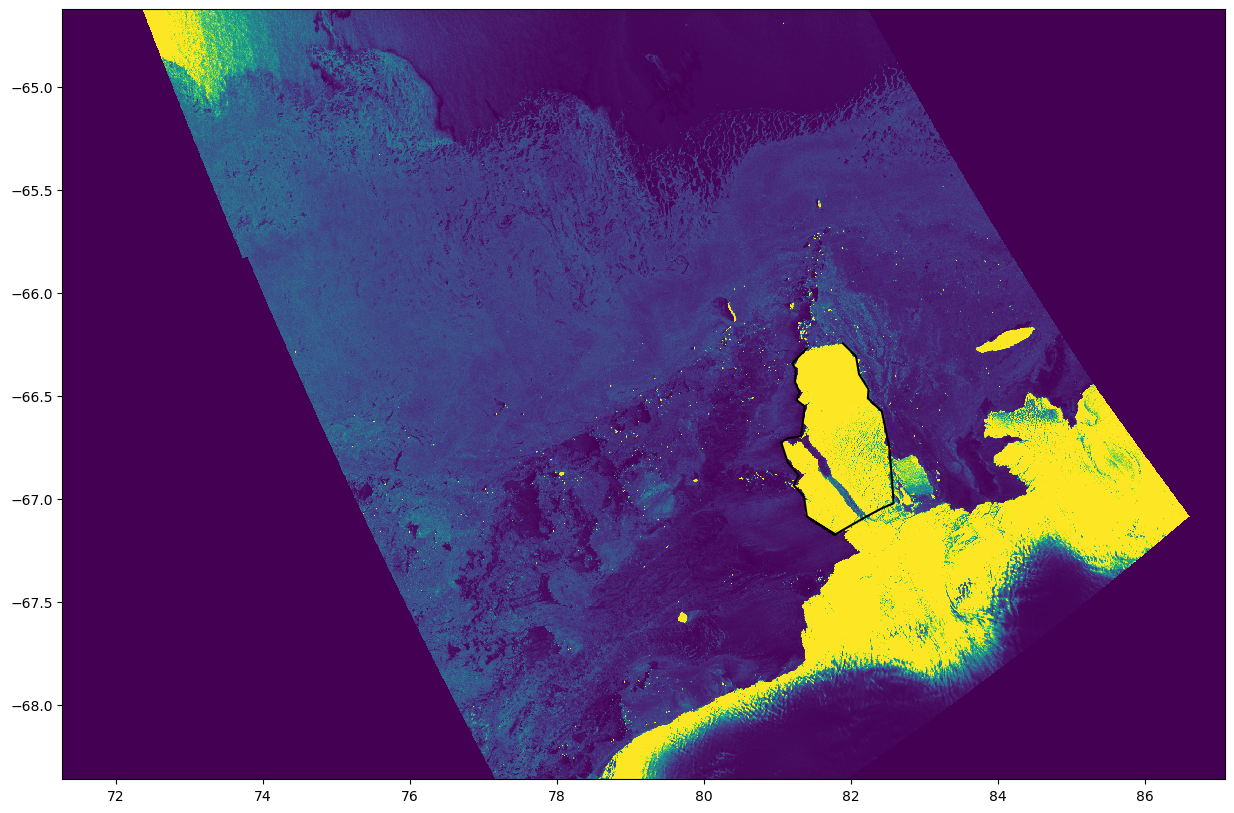

No such comm: e9931ded2970470aaa282af2903a239f


In [104]:
#define outline of icebergs (manually until vscode/jupyter can use plt.ginput())

d12=np.array([
[81.89,-66.246],
[82.07,-66.309],
[82.11,-66.396],
[82.24,-66.469],
[82.23,-66.513],
[82.42,-66.576],
[82.52,-66.746],
[82.56,-66.906],
[82.58,-67.023],
[82.42,-67.047],
[82.19,-67.091],
[81.79,-67.173],
[81.45,-67.100],
[81.79,-67.178],
[81.40,-67.086],
[81.36,-66.989],
[81.22,-66.935],
[81.29,-66.887],
[81.14,-66.824],
[81.05,-66.726],
[81.14,-66.707],
[81.32,-66.697],
[81.35,-66.615],
[81.37,-66.552],
[81.26,-66.522],
[81.30,-66.484],
[81.24,-66.435],
[81.25,-66.372],
[81.20,-66.343],
[81.40,-66.270 ]
])





def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_icebergs = inpolygon(grid.lon_rho.values, grid.lat_rho.values,d12[:,0], d12[:,1])



fig,ax=plt.subplots(figsize=(15,10))
im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
plt.plot(d12[:,0],d12[:,1],'k')

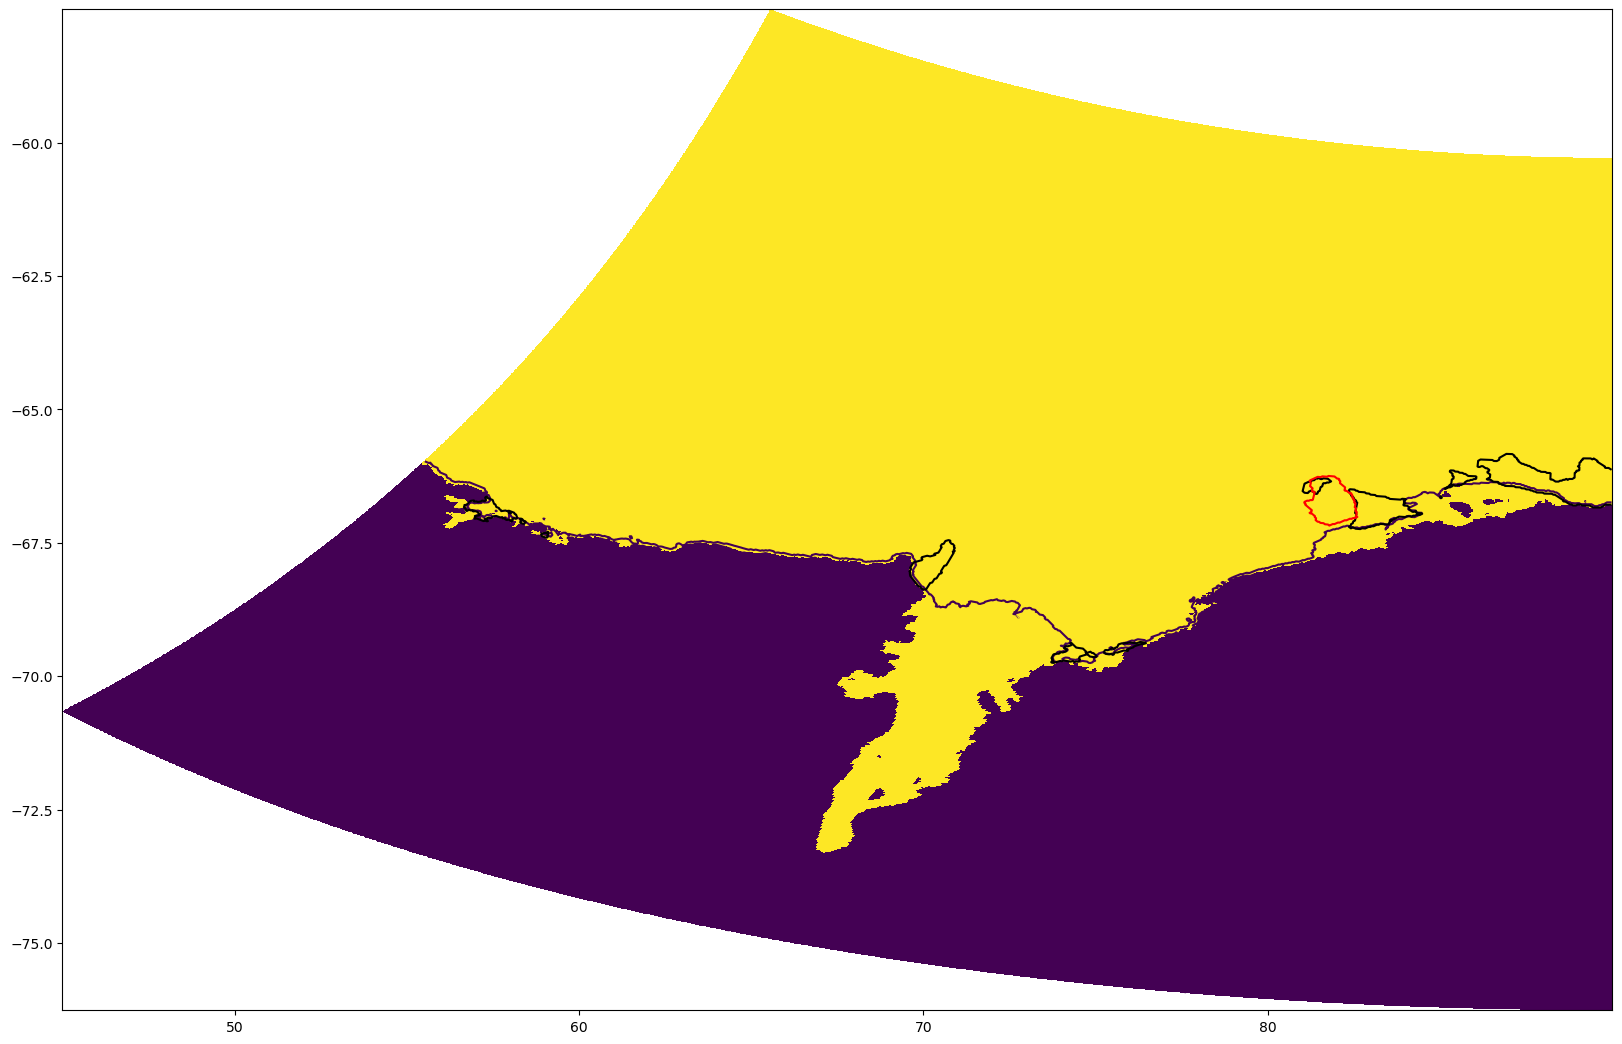

In [105]:

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(grid.lon_rho,grid.lat_rho,grid.mask_rho)
plt.contour(grid.lon_rho,grid.lat_rho,grid.zice,levels=np.array((-1,0)))

plt.contour(grid.lon_rho,grid.lat_rho,fi_mean_annual_i,colors='k')
plt.contour(grid.lon_rho,grid.lat_rho,mask_icebergs,colors='r')

In [106]:
znew = grid.zice
mnew = grid.mask_rho
h_old = grid.h

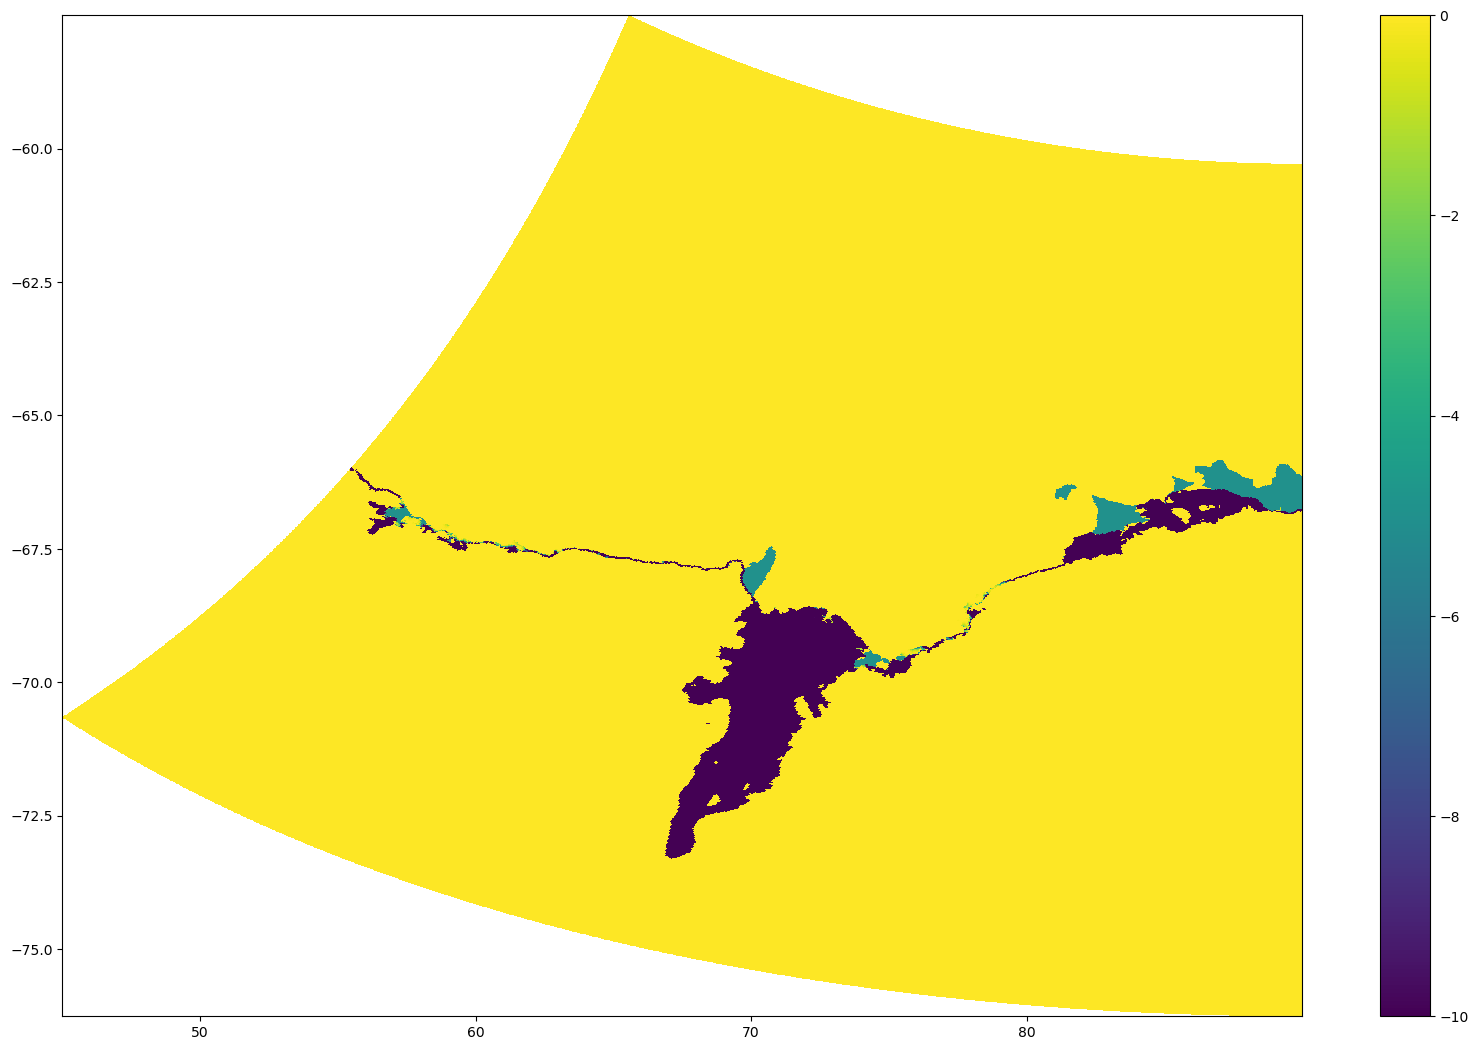

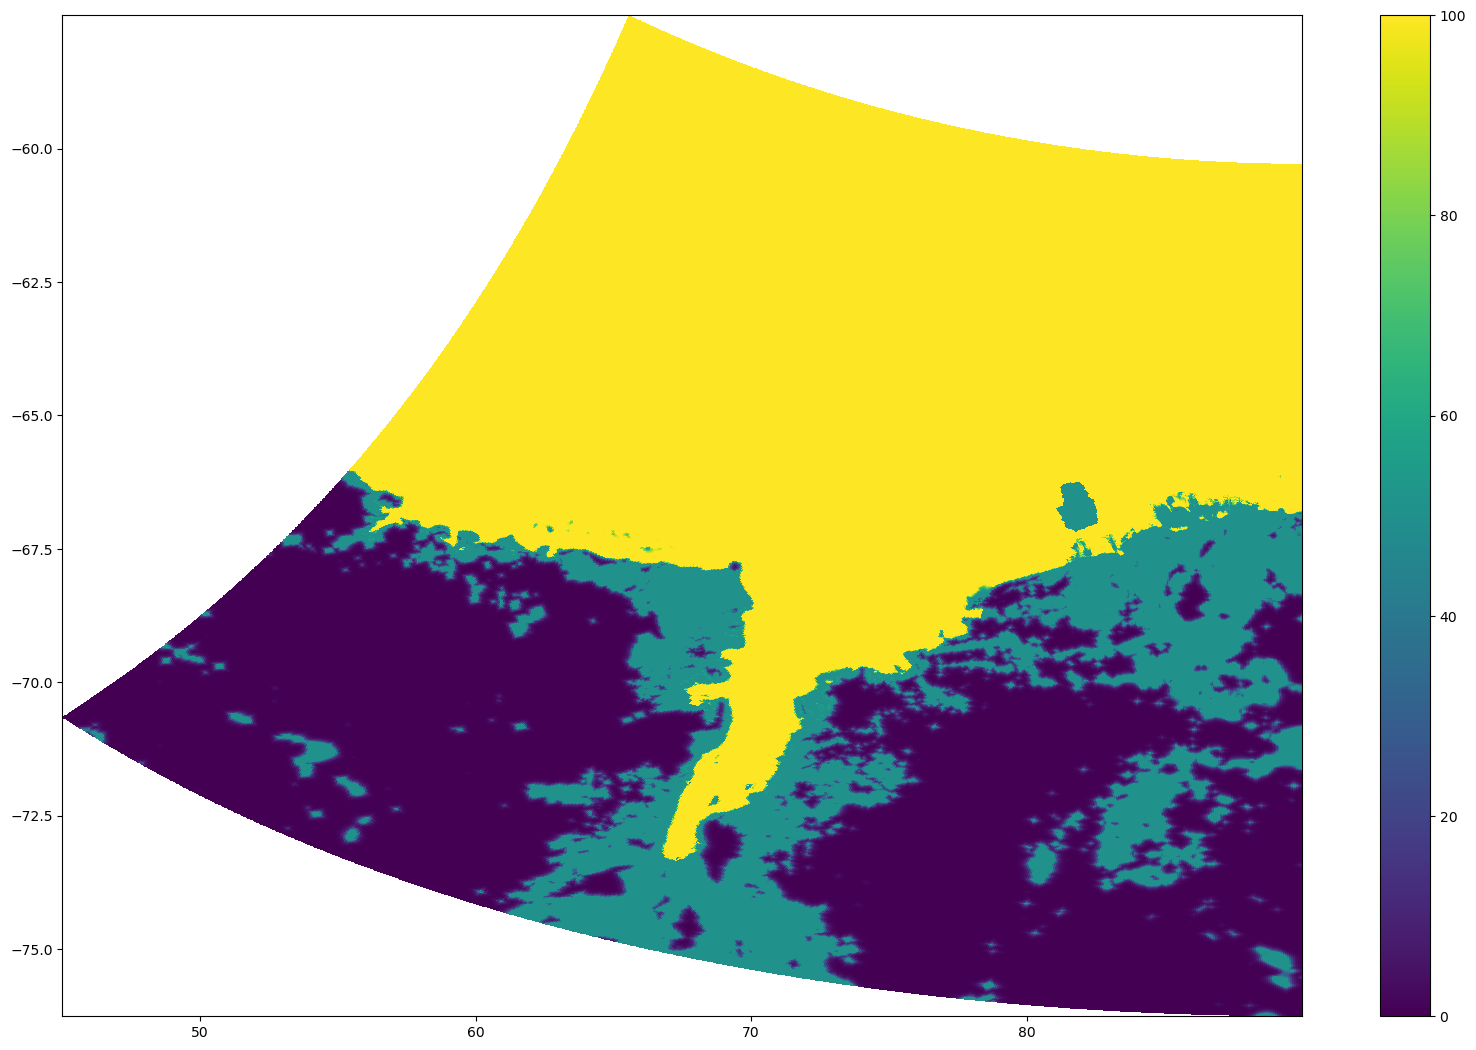

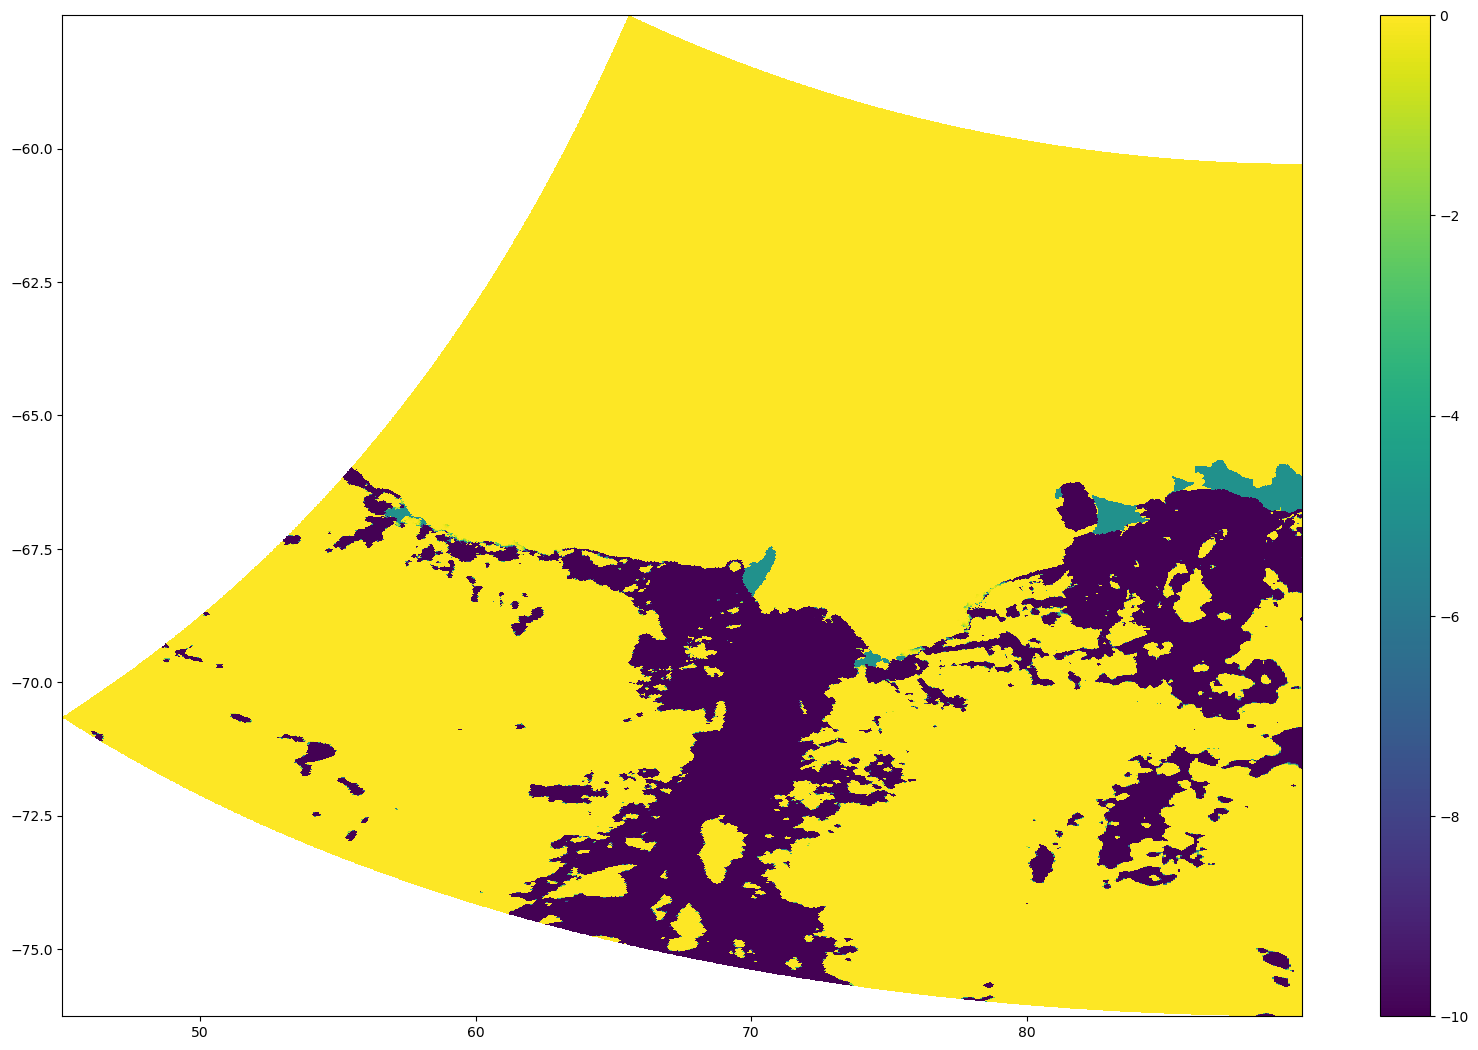

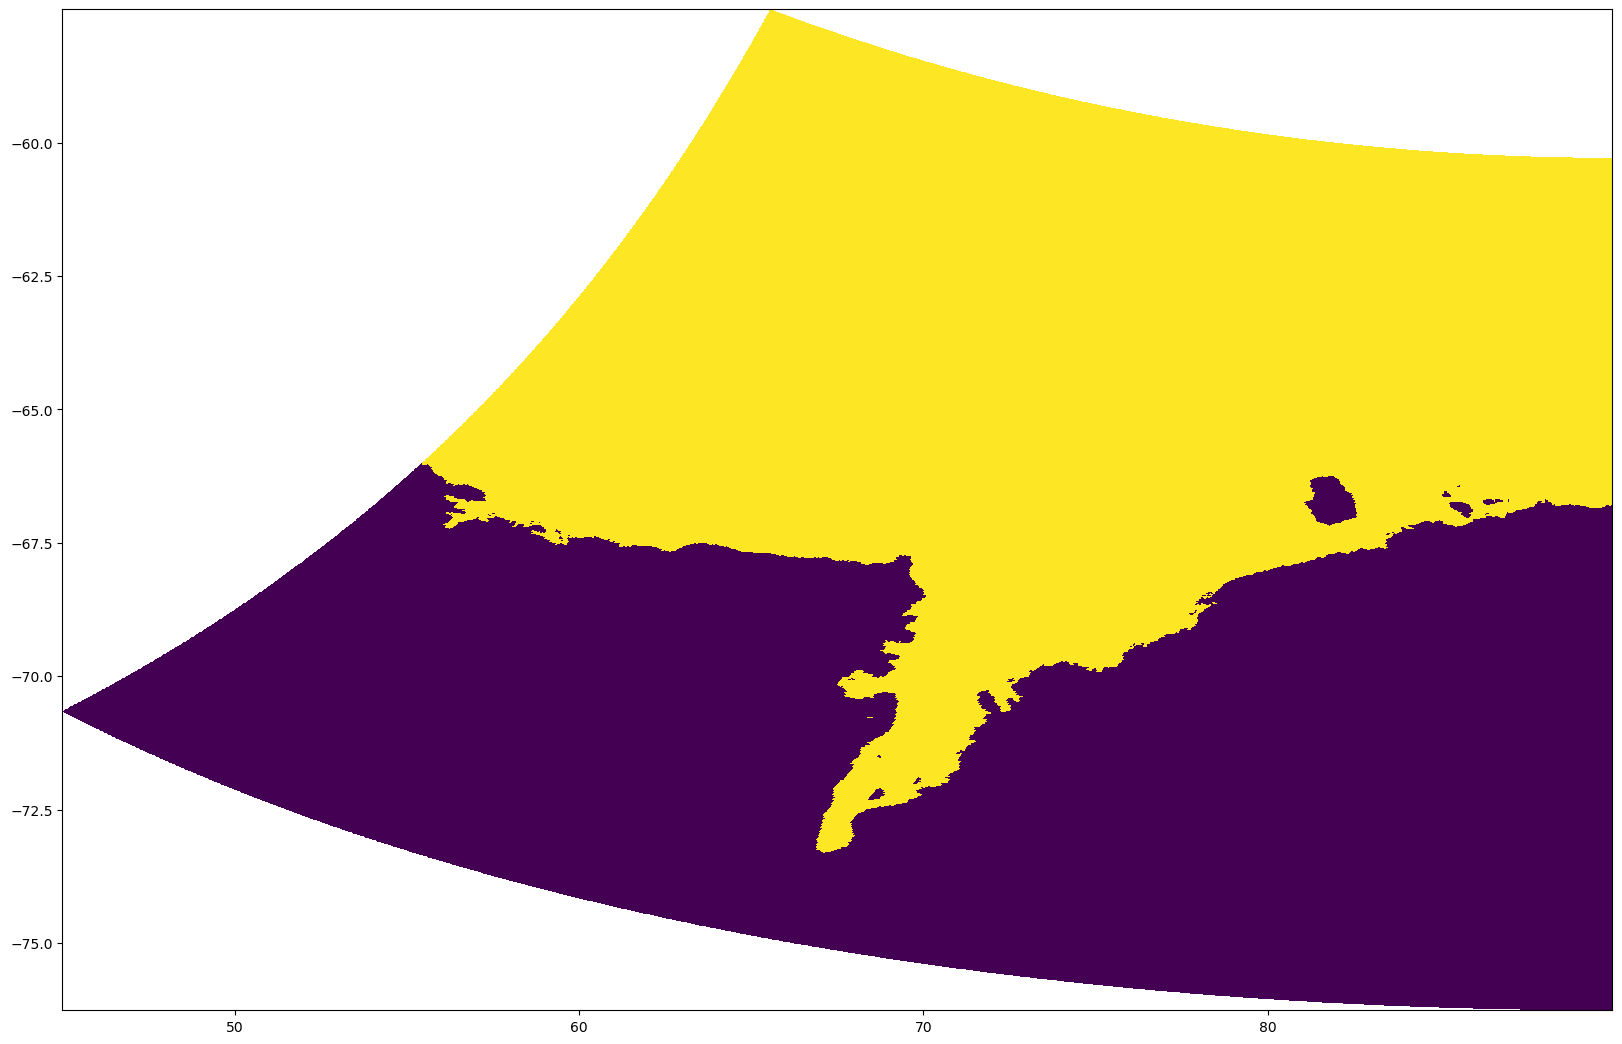

In [107]:
# for fast ice alter the zice.
fastice_draft = -5 #m below surface, negative downwards
min_depth=50

ii = ((fi_mean_annual_i==1) & (znew==0) & (mnew==1)) # logic mask for fastice, not already ice shelf, in the ocean
znew = znew.where(~ii,fastice_draft)

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(grid.lon_rho,grid.lat_rho,znew*grid.mask_rho,vmin=-10,vmax=0)
plt.colorbar()
plt.show()

# for icebergs, assume fully grounded.
ii = (mask_icebergs==1) # logic mask for ice berg
# zzz_test = zzz_test.where(ii,min_depth-hhh.where(ii))             # set ice to be min depth above bathy,
znew.values[ii] = min_depth-h_old.values[ii]
mnew.values[ii] = 0                                  # and remove from water, i.e. grounded.

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(grid.lon_rho,grid.lat_rho,(znew+h_old),vmin=0,vmax=100)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(grid.lon_rho,grid.lat_rho,znew,vmin=-10,vmax=0)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(20,13))
plt.pcolormesh(grid.lon_rho,grid.lat_rho,mnew)
plt.show()

In [114]:
maskNaN = mnew.values.astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',znew.values.min(),'/',znew.values.max())
print('min/max h is',h_old.values.min(),'/',h_old.values.max())
print('min/max wct is',(h_old.values+znew.values).min(),'/',(h_old.values+znew.values).max())
print('ocean cells')
print('min/max zice is',np.nanmin(znew.values*maskNaN),'/',np.nanmax(znew.values*maskNaN))
print('min/max h is',np.nanmin(h_old.values*maskNaN),'/',np.nanmax(h_old.values*maskNaN))
print('min/max wct is',np.nanmin((h_old.values+znew.values)*maskNaN),'/',np.nanmax((h_old.values+znew.values)*maskNaN))

whole domain
min/max zice is -3749.7085 / 0.0
min/max h is 0.1 / 4838.785
min/max wct is 0.1 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 45.0 / 4838.78515625


In [109]:
# calculate final rx0 and rx1 values, check that you're happy before overwriting these
z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,h_old,znew)
grd_rx0_final=GridStiffness.rx0(h_old,mnew)

grd_rx1_final=GridStiffness.rx1(z_w_final,mnew)



  
Minimum r-value =  <xarray.DataArray 'h' ()>
array(0.)
Maximum r-value =  <xarray.DataArray 'h' ()>
array(0.31513405)
Mean    r-value =  <xarray.DataArray 'h' ()>
array(0.00734941)
Median  r-value =  0.0008913295459933579
  
Minimum r-value =  0.0
Maximum r-value =  347.0628673955596
Mean    r-value =  2.023244501273348
Median  r-value =  0.23932710407535046


In [110]:
mask = mnew.values.astype(float)
mindxy = min(np.hstack((1/grid.pm.values.flatten(),1/grid.pn.values.flatten())))
maskNaN = mnew.values.astype('float')
maskNaN[maskNaN == 0] = np.NaN
CFL = mindxy/abs(np.sqrt(9.81*(h_old+znew)))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

max fast DT in s following CFL:  8.67147445678711
max slow DT in s following CFL:  236.15961967599594
Set ROMS timestep settings of at least: 
 DT < 236.15961967599594 s 
 NDTFAST > 27.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.37158638959344
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8371586389593441


In [111]:
zice_new = znew
mask_rho_new = mnew

In [112]:
# the original grid ds needs to have mask, and zice overwritten

grd = grid

grd['zice'] = zice_new

grd['mask_rho'] = mask_rho_new

grd.attrs['history'] = grid.attrs['history']+'; updated with fastice and icebergs from mask_grid-add_FastIceBergs.ipynb on '+str(datetime.date.today())


In [113]:
print('saving to',out_path_new)
grd.to_netcdf(out_path_new,unlimited_dims='bath')

saving to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_FIbergs_grd.nc
